Question 1: Naive Bayes error rate
  10-fold cross validation total test error is 0.0819 on 0.9185823754789272 examples
____________________________
Question 3: Naive Bayes (Small Data). Please see question_3_NB.png for plots
  10-fold cross validation total test error 0.0905 total train error 0.0100on 10 examples
  10-fold cross validation total test error 0.0905 total train error 0.0600on 20 examples
  10-fold cross validation total test error 0.0948 total train error 0.0400on 30 examples
  10-fold cross validation total test error 0.0905 total train error 0.0725on 40 examples
  10-fold cross validation total test error 0.0948 total train error 0.0920on 50 examples
  10-fold cross validation total test error 0.0991 total train error 0.0967on 60 examples
  10-fold cross validation total test error 0.0991 total train error 0.0971on 70 examples
  10-fold cross validation total test error 0.0991 total train error 0.0938on 80 examples
  10-fold cross validation total test error 0.0862 tot

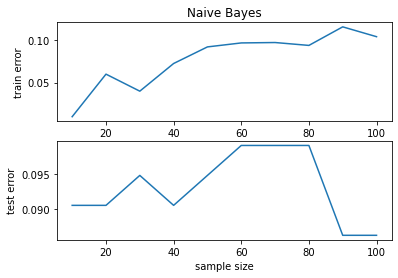

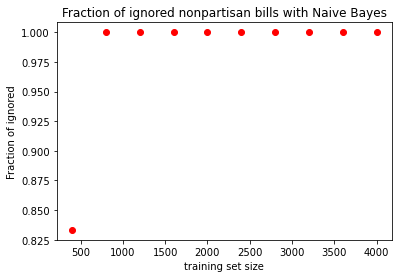

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 6 23:05:26 2022

@author: karlykussainova
"""


import os
import sys
import numpy as np
from collections import Counter
import random
import pdb
import math
import itertools
from itertools import product
import matplotlib.pyplot as plt

# helpers to load data
from data_helper import load_vote_data, load_incomplete_entry,load_simulate_data, generate_q4_data
# helpers to learn and traverse the tree over attributes

# pseudocounts for uniform dirichlet prior
alpha = 0.1


#--------------------------------------------------------------------------
# Naive bayes CPT and classifier
#--------------------------------------------------------------------------


class NBCPT(object):
  '''
  NB Conditional Probability Table (CPT) for a child attribute.  Each child
  has only the class variable as a parent
  '''

  def __init__(self, A_i):
    '''
    TODO create any persistent instance variables you need that hold the
    state of the learned parameters for this CPT
        - A_i: the index of the child variable
    '''
    super(NBCPT, self).__init__()
    self.c_count = [2*alpha, 2*alpha]
    self.pseudocounts = [alpha, alpha]
    self.i = A_i

  def learn(self, A, C):
    '''
    TODO
    populate any instance variables specified in __init__ to learn
    the parameters for this CPT
        - A: a 2-d numpy array where each row is a sample of assignments
        - C: a 1-d n-element numpy where the elements correspond to the
          class labels of the rows in A
    '''
    for i in range(2):
      self.c_count[i] = self.c_count[i] + len(C[C == i])
      self.pseudocounts[i] = self.pseudocounts[i] + len(C[(A[:, self.i] == 1) & (C == i)])


  def get_cond_prob(self, entry, c):
    ''' TODO
    return the conditional probability P(A_i|C=c) for the values
    specified in the example entry and class label c
        - entry: full assignment of variables
            e.g. entry = np.array([0,1,1]) means A_0 = 0, A_1 = 1, A_2 = 1
        - c: the class
    '''
    is_one_prob = self.pseudocounts[c] / float(self.c_count[c])
#     if entry[self.i] == 1:
#         return is_one_prob
#     else:
#         (1 - is_one_prob)
    return is_one_prob if entry[self.i] == 1 else (1 - is_one_prob)

class NBClassifier(object):
  '''
  NB classifier class specification
  '''

  def __init__(self, A_train, C_train):
    '''
    TODO create any persistent instance variables you need that hold the
    state of the trained classifier and populate them with a call to
    Suggestions for the attributes in the classifier:
        - P_c: the probabilities for the class variable C
        - cpts: a list of NBCPT objects
    '''
    super(NBClassifier, self).__init__()
    assert(len(np.unique(C_train))) == 2
    n, m = A_train.shape
#     for i in range(m):
#         self.cpts = NBCPT(i)
    self.cpts = [NBCPT(i) for i in range(m)]
    self.P_c = 0.0
    self._train(A_train, C_train)

  def _train(self, A_train, C_train):
    ''' TODO
    train your NB classifier with the specified data and class labels
    hint: learn the parameters for the required CPTs
        - A_train: a 2-d numpy array where each row is a sample of assignments
        - C_train: a 1-d n-element numpy where the elements correspond to
          the class labels of the rows in A
    '''
    q1 = len(C_train[C_train == 1])
    q2 = (len(C_train))
    self.P_c = q1 / float(q2)
    
    for cpt in self.cpts:
      cpt.learn(A_train, C_train)

  def classify(self, entry):
    ''' TODO
    return the log probabilites for class == 0 and class == 1 as a
    tuple for the given entry
    - entry: full assignment of variables
    e.g. entry = np.array([0,1,1]) means variable A_0 = 0, A_1 = 1, A_2 = 1
    NOTE this must return both the predicated label {0,1} for the class
    variable and also the log of the conditional probability of this
    assignment in a tuple, e.g. return (c_pred, logP_c_pred)
    '''
    unobserved_lst = [i for i, e in enumerate(entry) if e == -1]
    P_c_pred = [0, 0]
 
    unobserved_assg = list(itertools.product(
        (0, 1), repeat=len(unobserved_lst))) + [[]]
    
    for unobserved_assigment in unobserved_assg:
      p = 0.0
      for i, value in enumerate(unobserved_assigment):
        entry[unobserved_lst[i]] = value

      P_c_pred_full = [1 - self.P_c, self.P_c]
      for cpt in self.cpts:
        for i in range(2):
          P_c_pred_full[i] *= cpt.get_cond_prob(entry, i)

      for i in range(2):
        P_c_pred[i] += P_c_pred_full[i]
        
    P_c_pred = P_c_pred / np.sum(P_c_pred)
    c_pred = np.argmax(P_c_pred)
    return (c_pred, np.log(P_c_pred[c_pred]))















  def predict_unobserved(self, entry, index):
    ''' TODO
    Predicts P(A_index  | mid entry)
    Return a tuple of probabilities for A_index=0  and  A_index = 1
    We only use the 2nd value (P(A_index =1 |entry)) in this assignment
    '''
    if entry[index] == 1 or entry[index] == 0:
      return [1-entry[index], entry[index]]
#     for i,e in enumerate(entry):
#         if e == -1 and i!= index:
#             unobserved_lst = i
    unobserved_lst = [i for i, e in enumerate(entry) if e == -1 and i != index]
    P_index_pred = [0.0, 0.0]

    
    

    
    unobserved_assg = list(itertools.product(
        (0, 1), repeat=len(unobserved_lst))) + [[]]
    for p_val in range(2):
      entry[index] = p_val
      for unobserved_assigment in unobserved_assg:
        p = 0.0
        for i, value in enumerate(unobserved_assigment):
          entry[unobserved_lst[i]] = value

        P_c_pred_full = [1 - self.P_c, self.P_c]
        for cpt in self.cpts:
          for i in range(2):
            P_c_pred_full[i] *= cpt.get_cond_prob(entry, i)

            P_index_pred[p_val] += np.sum(P_c_pred_full)

      
    P_index_pred /= np.sum(P_index_pred)
    return P_index_pred




# load data
A_data, C_data = load_vote_data()


def evaluate(classifier_cls, train_subset=False, subset_size = 0):
  '''
  evaluate the classifier specified by classifier_cls using 10-fold cross
  validation
  - classifier_cls: either NBClassifier or other classifiers
  - train_subset: train the classifier on a smaller subset of the training
    data
  -subset_size: the size of subset when train_subset is true
  NOTE you do *not* need to modify this function
  '''
  global A_data, C_data

  A, C = A_data, C_data


  # partition train and test set for 10 rounds
  M, N = A.shape
  tot_correct = 0
  tot_test = 0
  train_correct = 0
  train_test = 0
  step = int(M / 10 + 1)
  for holdout_round, i in enumerate(range(0, M, step)):
    # print("Holdout round: %s." % (holdout_round + 1))
    A_train = np.vstack([A[0:i, :], A[i+step:, :]])
    C_train = np.hstack([C[0:i], C[i+step:]])
    A_test = A[i: i+step, :]
    C_test = C[i: i+step]
    if train_subset:
      A_train = A_train[: subset_size, :]
      C_train = C_train[: subset_size]
    # train the classifiers
    classifier = classifier_cls(A_train, C_train)

    train_results = get_classification_results(classifier, A_train, C_train)
    # print(
    #    '  train correct {}/{}'.format(np.sum(train_results), A_train.shape[0]))
    test_results = get_classification_results(classifier, A_test, C_test)
    tot_correct += sum(test_results)
    tot_test += len(test_results)
    train_correct += sum(train_results)
    train_test += len(train_results)

  return 1.*tot_correct/tot_test, 1.*train_correct/train_test


  # score classifier on specified attributes, A, against provided labels,
  # C
def get_classification_results(classifier, A, C):
  results = []
  pp = []
  for entry, c in zip(A, C):
    c_pred, unused = classifier.classify(entry)
    results.append((c_pred == c))
    pp.append(unused)
    # print('logprobs', np.array(pp))
  return results



def evaluate_incomplete_entry(classifier_cls):

  global A_data, C_data

  # train a classifier on the full dataset
  classifier = classifier_cls(A_data, C_data)

  # load incomplete entry 1
  entry = load_incomplete_entry()

  c_pred, logP_c_pred = classifier.classify(entry)
  print("  P(C={}|A_observed) = {:2.4f}".format(c_pred, np.exp(logP_c_pred)))

  return


def predict_unobserved(classifier_cls, index=11):
  global A_data, C_data

  # train a classifier on the full dataset
  classifier = classifier_cls(A_data, C_data)
  # load incomplete entry 1
  entry = load_incomplete_entry()

  a_pred = classifier.predict_unobserved(entry, index)
  print("  P(A{}=1|A_observed) = {:2.4f}".format(index+1, a_pred[1]))

  return


def main():

  '''
  TODO modify or use the following code to evaluate your implemented
  classifiers
  Suggestions on how to use the starter code for Q2, Q3, and Q5:


  ##For Q1
  print('Naive Bayes')
  accuracy, num_examples = evaluate(NBClassifier, train_subset=False)
  print('  10-fold cross validation total test error {:2.4f} on {} '
        'examples'.format(1 - accuracy, num_examples))
  ##For Q3
  print('Naive Bayes (Small Data)')
  train_error = np.zeros(10)
  test_error = np.zeros(10)
  for x in range(10):
    accuracy, train_accuracy = evaluate(NBClassifier, train_subset=True,subset_size = (x+1)*10)
    train_error[x] = 1-train_accuracy
    test_error[x] = 1- accuracy
    print('  10-fold cross validation total test error {:2.4f} total train error {:2.4f}on {} ''examples'.format(1 - accuracy, 1- train_accuracy  ,(x+1)*10))
  print(train_error)
  print(test_error)
  ##For Q4 TODO
  ##For Q5
  print('Naive Bayes Classifier on missing data')
  evaluate_incomplete_entry(NBClassifier)

  index = 11
  print('Prediting vote of A%s using NBClassifier on missing data' % (
      index + 1))
  predict_unobserved(NBClassifier, index)
 '''
# Q1
  print('Question 1: Naive Bayes error rate')
  accuracy, num_examples = evaluate(NBClassifier, train_subset=False)
  print('  10-fold cross validation total test error is {:2.4f} on {} '
        'examples'.format(1-accuracy, num_examples))
  print('____________________________')

    
#Q3    
  print('Question 3: Naive Bayes (Small Data). Please see question_3_NB.png for plots')
    
  train_error = np.zeros(10)
  test_error = np.zeros(10)
  example_number = np.zeros(10)
  for x in range(10):
    example_number[x] = (x+1)*10
    accuracy, train_accuracy = evaluate(NBClassifier, train_subset=True,subset_size = (x+1)*10)
    train_error[x] = 1-train_accuracy
    test_error[x] = 1- accuracy
    print('  10-fold cross validation total test error {:2.4f} total train error {:2.4f}on {} ''examples'.format(1 - accuracy, 1- train_accuracy  ,(x+1)*10))
  #print(train_error)
  #print(test_error)
    
    
    
  plt.figure()
  plt.subplot(211)
  plt.plot((example_number), train_error)
  plt.ylabel('train error')
  plt.title('Naive Bayes')

  plt.subplot(212)
  plt.plot((example_number), test_error)
  plt.ylabel('test error')
  plt.xlabel('sample size')
  plt.savefig('question_3_NB.png')

 

    
  print('____________________________')
#Q4
  print('Question 4: Generating samples (see new_q4_data_NB_.csv files) and a plotting the fraction of nonpartisan bills(see NB_q4.png)')
  random.seed(1234)
  np.random.seed(1234)
  n_nonpartisan = 12
  feature_size = 16
  training_set_size = []
  fraction_ignored_arr = []
  diff = np.zeros((10, feature_size))
  probabilites = np.zeros((10, 2, feature_size))
  threshold = 0.1
  i = 0
  entry = [1]*feature_size
  for size in range(400, 4001, 400):
    i += 1
    training_set_size.append(size)
    file_name = "new_q4_data_NB_{}.csv".format(size)
    generate_q4_data(size, file_name)
    A, C = load_simulate_data(file_name)

    classifier = NBClassifier(A, C)

    for index, cpt in enumerate(classifier.cpts):
      for c in [0, 1]:
        probabilites[i-1, c, index] = cpt.get_cond_prob(entry, c)


    n_nonpartisan_ignored = 0
    for j in range(4, feature_size):
      diff[i-1, j] = np.abs(probabilites[i-1, 1, j] - probabilites[i-1, 0, j])

      if diff[i-1, j] < 0.1:
        n_nonpartisan_ignored += 1

    fraction_ignored = float(n_nonpartisan_ignored)/n_nonpartisan
    fraction_ignored_arr.append(fraction_ignored)
    
    
  # Plot
  plt.figure()
  plt.scatter(training_set_size, fraction_ignored_arr, color='red')
  plt.ylabel('Fraction of ignored')
  plt.xlabel('training set size')
  plt.title('Fraction of ignored nonpartisan bills with Naive Bayes')
  plt.savefig('NB_q4.png')
  # plt.show()

  print('____________________________')
#Q5
  print('Question 5: Naive Bayes Classifier on missing data')
  evaluate_incomplete_entry(NBClassifier)

  index = 11
  print('Prediting vote of A%s using NBClassifier on missing data' % (
      index + 1))
  predict_unobserved(NBClassifier, index)



if __name__ == '__main__':
  main()


____________________________
Question 2:
10-fold cross validation error is 0.03017241379310345
____________________________
Question 3: LASSO (Small Data). Please, see question_3_Lasso.png for plots


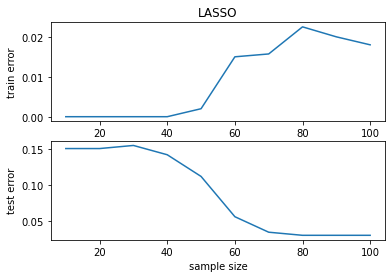

____________________________
Question 4: Generating samples (see new_q4_data_Lasso_.csv files) and a plotting the fraction of nonpartisan bills(see Lasso_q4.png)
____________________________
Question 5:
LASSO  P(C=1|A_observed) 
[0.93227933]


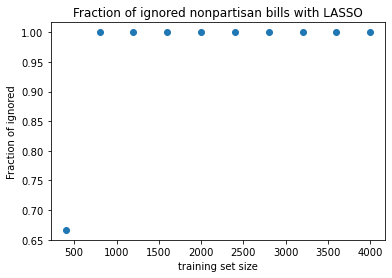

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 6 23:06:30 2022

@author: karlykussainova
"""



import pandas as pd
import numpy as np
import sys
import random
import matplotlib
import matplotlib.pyplot as plt

from data_helper import generate_q4_data, load_simulate_data
from data_helper import load_vote_data, load_incomplete_entry,load_simulate_data, generate_q4_data


from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error


# load data
dpa = pd.read_csv('./data/house-votes-84.complete.csv')
dpa['Class'] = dpa['Class'].map({'republican': 0, 'democrat': 1})
for i in range(16):
	index = 'A'+ str(i+1)
	dpa[index] = dpa[index].map({'y': 1, 'n': 0})
#dpa.info()

pay = dpa.Class
paX = dpa.drop('Class', axis = 1)



'''
  10-cv with house-votes-84.complete.csv using LASSO
  - train_subset: train the classifier on a smaller subset of the training
    data
  -subset_size: the size of subset when train_subset is true 
  NOTE you do *not* need to modify this function
  '''
def lasso_evaluate(train_subset=False, subset_size = 0):
	sample_size = pay.shape[0]
	tot_incorrect=0
	tot_test=0
	tot_train_incorrect=0
	tot_train=0
	step = int( sample_size/ 10 + 1)
	for holdout_round, i in enumerate(range(0, sample_size, step)):
		#print("CV round: %s." % (holdout_round + 1))
		if(i==0):
			X_train = paX.iloc[i+step:sample_size]
			y_train = pay.iloc[i+step:sample_size]
		else:
			X_train =paX.iloc[0:i]  
			X_train = X_train.append(paX.iloc[i+step:sample_size], ignore_index=True)
			y_train = pay.iloc[0:i]
			y_train = y_train.append(pay.iloc[i+step:sample_size], ignore_index=True)
		X_test = paX.iloc[i: i+step]
		y_test = pay.iloc[i: i+step]
		if(train_subset):
			X_train = X_train.iloc[0:subset_size]
			y_train = y_train.iloc[0:subset_size]
		#print(" Samples={} test = {}".format(y_train.shape[0],y_test.shape[0]))
		# train the classifiers
		lasso = Lasso(alpha = 0.001)
		lasso.fit(X_train, y_train)            
		lasso_predit = lasso.predict(X_test)           # Use this model to predict the test data
		lasso_result = [1 if x>0.5 else 0 for x in lasso_predit]
		error = 0
		for (index, num) in enumerate(lasso_result):
			if(y_test.values.tolist()[index] != num):
				error+=1
		tot_incorrect += error
		tot_test += len(lasso_result)
		#print('Error rate {}'.format(1.0*error/len(lasso_result)))
		lasso_predit = lasso.predict(X_train)           # Use this model to get the training error
		lasso_result = [1 if x>0.5 else 0 for x in lasso_predit]
		error = 0
		for (index, num) in enumerate(lasso_result):
			if(y_train.values.tolist()[index] != num):
				error+=1
		tot_train_incorrect+= error
		tot_train += len(lasso_result)
		#print('Train Error rate {}'.format(1.0*error/len(lasso_result)))		

	#print('10CV Error rate {}'.format(1.0*tot_incorrect/tot_test))
	#print('10CV train Error rate {}'.format(1.0*tot_train_incorrect/tot_train))

	return 1.0*tot_incorrect/tot_test, 1.0*tot_train_incorrect/tot_train

def lasso_evaluate_incomplete_entry():
	# get incomplete data
	dpc = pd.read_csv('./data/house-votes-84.incomplete.csv')
	for i in range(16):
		index = 'A'+ str(i+1)
		dpc[index] = dpc[index].map({'y': 1, 'n': 0})
		
	lasso = Lasso(alpha = 0.001)
	lasso.fit(paX, pay)
	lasso_predit = lasso.predict(dpc)
	print(lasso_predit)


def main():
	#For Q2
	print('____________________________')
	print('Question 2:')
	error_rate, unused = lasso_evaluate()
	print('10-fold cross validation error is {}'.format(error_rate))

	
	#For Q3
	print('____________________________')
	print('Question 3: LASSO (Small Data). Please, see question_3_Lasso.png for plots')
	train_error = np.zeros(10)
	test_error = np.zeros(10)
	example_number = np.zeros(10)

	for i in range(10):
		example_number[i] = (i+1)*10
		x, y =lasso_evaluate(train_subset=True, subset_size=i*10+10)
		train_error[i] = y
		test_error[i] = x

	plt.figure()
	plt.subplot(211)
	plt.plot(example_number, train_error)
	plt.ylabel('train error')
	plt.title('LASSO')

	plt.subplot(212)
	plt.plot(example_number, test_error)
	plt.ylabel('test error')
	plt.xlabel('sample size')
	plt.savefig('question_3_Lasso.png')
	plt.show()
	
	
	#Q4
	#TODO 
	print('____________________________')
	print('Question 4: Generating samples (see new_q4_data_Lasso_.csv files) and a plotting the fraction of nonpartisan bills(see Lasso_q4.png)')

	#random.seed(1234)
	#np.random.seed(1234)
	EPS = sys.float_info.epsilon
	nonpartisian = 12
	training_set_size = []
	fraction_ign_lst = []
    
	for i in range(400, 4001, 400):
		training_set_size.append(i)
		file_name = "new_q4_data_Lasso{}.csv".format(i)
		generate_q4_data(i, file_name)

		# load data
		dpa = pd.read_csv(file_name)
		dpa['Class'] = dpa['Class'].map({'republican': 0, 'democrat': 1})
		for i in range(16):
			index = 'A'+ str(i+1)
			dpa[index] = dpa[index].map({'y': 1, 'n': 0})
		pay = dpa.Class
		paX = dpa.drop('Class', axis = 1)

        # Apply Lasso
		lasso = Lasso(alpha = 0.001)
		lasso.fit(paX, pay)

		coefs = lasso.coef_

		
		nonpartisian_ignored = 0
		for j in range(4, 16):
			if abs(coefs[j])<0.01:
				nonpartisian_ignored = nonpartisian_ignored + 1
				
		fraction_ignored = float(nonpartisian_ignored)/nonpartisian
		fraction_ign_lst.append(fraction_ignored)

	# Plot
	plt.figure()
	plt.scatter(training_set_size, fraction_ign_lst)
	plt.title('Fraction of ignored nonpartisan bills with LASSO')
	plt.xlabel('training set size')
	plt.ylabel('Fraction of ignored')
	plt.savefig('Lasso_q4.png')
	#plt.show()
	

	#Q5
	print('____________________________')
	print('Question 5:')
	print('LASSO  P(C=1|A_observed) ')
	lasso_evaluate_incomplete_entry()
	

if __name__ == "__main__":
    main()

In [7]:
EPS = sys.float_info.epsilon
EPS

2.220446049250313e-16